<a href="https://colab.research.google.com/github/jpmvbastos/AppliedEconometrics3/blob/main/Homework1/Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1







In [20]:
import pandas as pd 
import numpy as np
import seaborn as sns 
sns.set_style('darkgrid')
from scipy import stats 
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Poisson
from statsmodels.base.model import GenericLikelihoodModel


## 1) Estimating a demand function

Consider the following equation, where the quantity exported of a good ($Q$) is related to the export price ($P$) and the price of a substitute good ($P_s$) as:


$Q_t = \beta_1 + \frac{\beta_2(P^\lambda_t - 1)}{\lambda} + \frac{\beta_3(P^\lambda_{st} - 1)}{\lambda} + \epsilon_t$

In [21]:
# Import the data
df = pd.read_excel('data_1.xlsx')

### a) Estimate $\beta_1$, $\beta_2$, and $\beta_3$ by regressing $Q_t$, on $P$, and $P_s$. Interpret your results:

In [22]:
print(sm.OLS(df.Q,df.iloc[:,1:]).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      Q   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              155.6
Date:                Mon, 10 Oct 2022   Prob (F-statistic):                    2.05e-20
Time:                        20:18:36   Log-Likelihood:                         -290.22
No. Observations:                  45   AIC:                                      584.4
Df Residuals:                      43   BIC:                                      588.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

A $1 increase in the price of the good is associate with a reduction of 1.5 units in quantity exported, all else equal. 

A $1 increase in the price of the substitute good is associated with an increase of 4 units in quantity exported, all else equal.

### b) Estimate the parameters using maximum likelihood method and compare your results to (a).

Assume $\epsilon \sim N(0,\sigmaˆ2)$ 

This part was performed in Stata using the ```boxcox``` command. The results are presented below: 

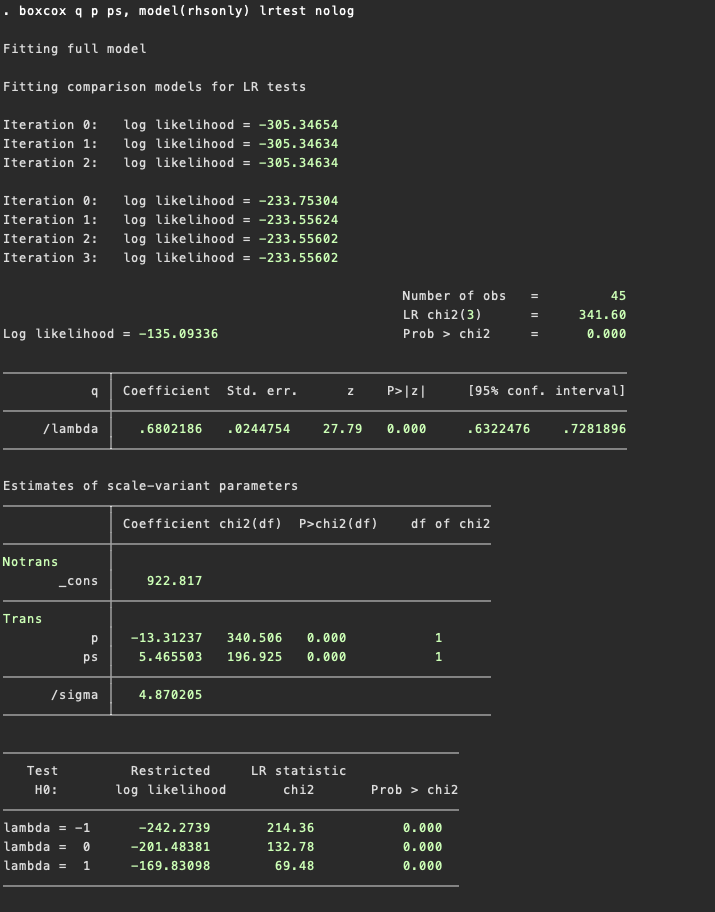

A tentative alternative is to use Python to estimate the same values by optimizing the log-likelihood function using ```scipy.Optimize``` library.

In [ ]:
def llboxcox(params):
    """Log Likelihood for the Box Cox Model"""
    b0=params[0]
    b1=params[1]
    b2=params[2]
    l1=params[3]
    l2=params[4]
    return -((-len(df)/2)*(np.log(2*np.pi)) + 1 + np.log(sum((y-b0*np.ones(len(df)) - b1*((x1**l1 - 1)/(l1+0.0001)) -  b2*((x2**l2 - 1)/(l2+0.0001))**2)/len(df))+1))

In [ ]:
def llboxcox(params):
    """Log Likelihood for the Box Cox Model"""
    b0=params[0]
    b1=params[1]
    b2=params[2]
    l1 = stats.boxcox(x1)
    l2 = stats.boxcox(x2)
    sigma = sum((y-b0*np.ones(len(df)) - b1*((x1**l1[-1] - 1)/l1[-1]) -  b2*((x2**l2[-1] - 1)/l2[-1])))/len(df)
    print(sigma)
    if sigma==0:
        LL = -((-len(df)/2)*(np.log(2*np.pi)) + 1 + np.log((sigma+0.0001)**2))
    else: 
        LL = -((-len(df)/2)*(np.log(2*np.pi)) + 1 + np.log(sigma**2)/len(df))
    return LL

In [ ]:
# Convert data to np.arrays
y = np.array(df.Q) 
x1 = np.array(df.P)
x2 = np.array(df.PS)

# Define the objective function:
x0 = np.array([1, -10, 5, .5, .5])
results = minimize(llboxcox, x0, method='powell')

### c) Test the hypothesis $H_0: \beta_2 = -\beta_3$

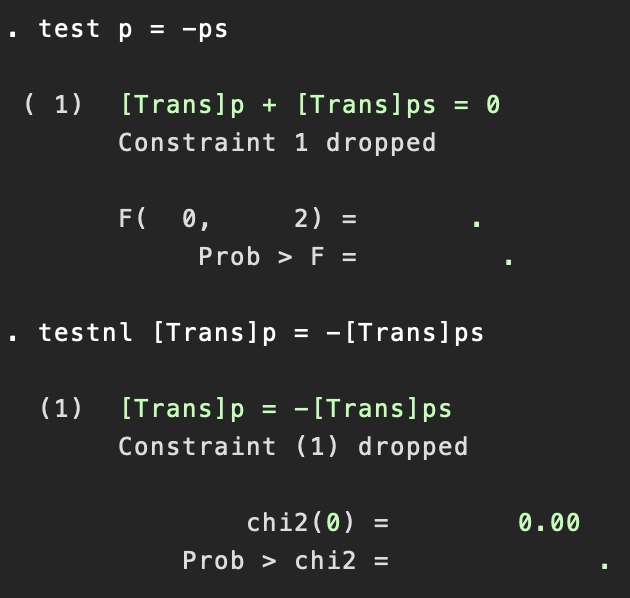

In Stata, Box-Cox estimates variances only for the $\lambda$ parameter, and formulas used in ```test```, and ```testnl``` are dependent on the estimated variances. The technical note in [boxcox postestimation commands](https://www.stata.com/manuals/rboxcoxpostestimation.pdf#rboxcoxpostestimation) (p.4), says that "use of these commands is limited and generally applicable only to inferences on the $\lambda$ and $\theta$ coefficients".

Thus, we can re-estimate the values using Stata's  ```mlexp``` command (also as a robustness check) and perform the tests again. 

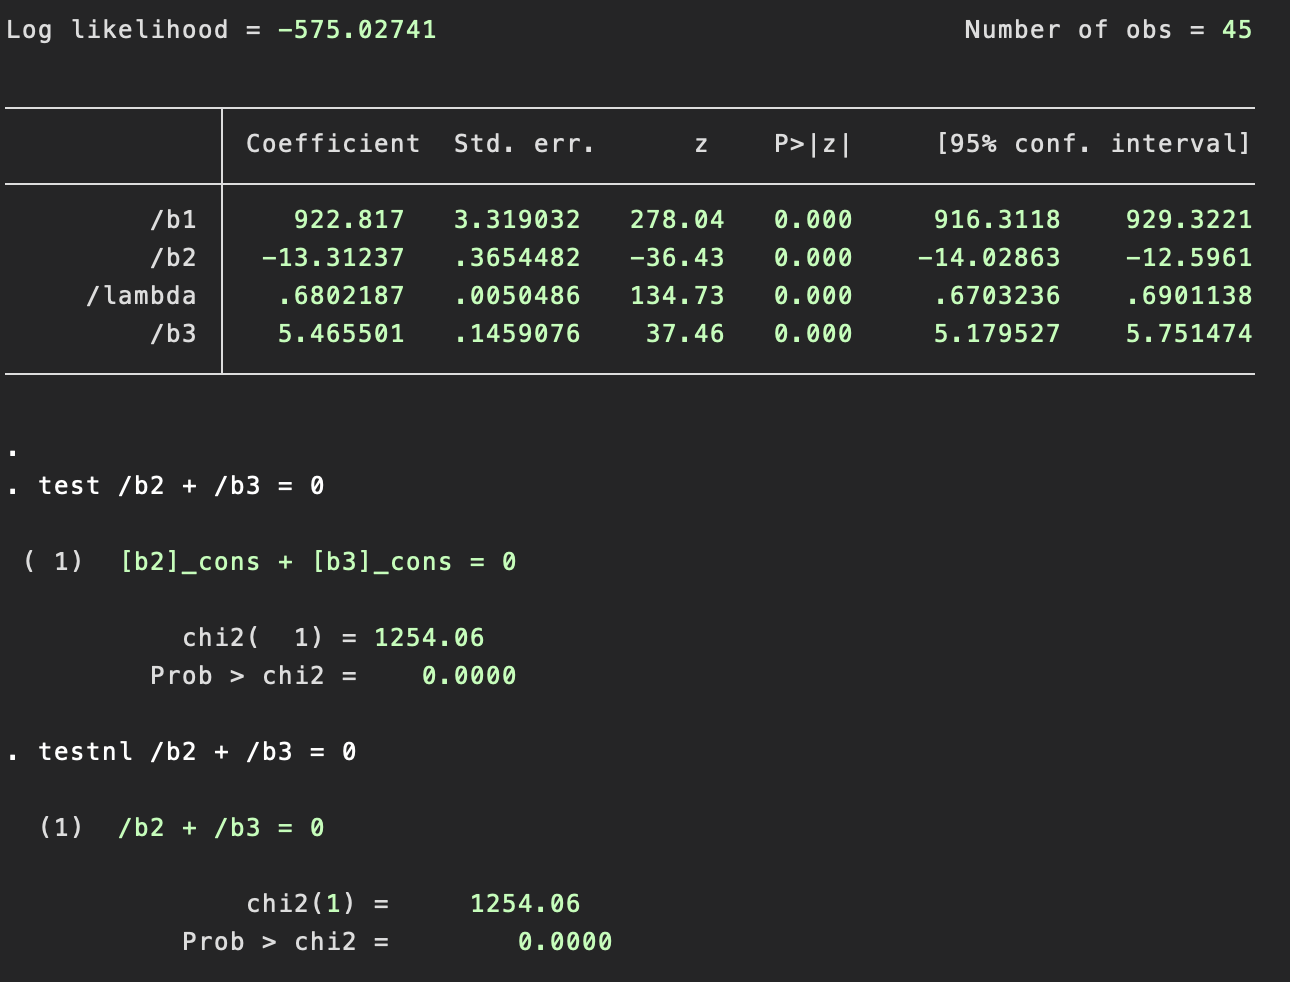

As it can be seem from the output table, the returned coefficients are identical to those obtained by the ```boxcox``` command. 

Moreover, the test indicate that we should reject the null hypothesis $\beta_2 = - \beta_3$

### d) Find own and cross-price elasticities at the mean

The own-price elasticity is given by

$\epsilon_{P} = \frac{\partial Q}{\partial P} \times \frac{P}{Q} = \frac{\lambda\beta_2}{\lambda}P^{\lambda-1} = \beta_2P^{\lambda-1} \times\frac{P}{Q}$

whereas the cross-price elasticity is given by 

$\epsilon_{PS} = \frac{\partial Q}{\partial P}\times \frac{PS}{Q} = \frac{\lambda \beta_3}{\lambda}PS^{\lambda -1} = \beta_3PS^{\lambda-1}\times\frac{PS}{Q}$



In [23]:
#Get mean values of P and PS and Q
Qbar = np.mean(df.Q)
Pbar = np.mean(df.P)
PSbar = np.mean(df.PS)

# Coefficients
lmbda = .6802186
b2 = -13.3123
b3 = 5.465503

own_elasticity = (b2*Pbar**(lmbda-1))*Pbar/Qbar
cross_elasticity = (b3*PSbar**(lmbda-1))*PSbar/Qbar

print('The Own-Price elasticity is =' + str(own_elasticity))
print('The Cross-Price elasticity is =' + str(cross_elasticity))

The Own-Price elasticity is =-1.494736647383519
The Cross-Price elasticity is =0.48982473455209813


### e) Comparing Models

Now, estimate the following model: 

$Q_t = \beta_1 + \frac{\beta_2(P^{\lambda_1}_t - 1)}{\lambda_1} + \frac{\beta_3(PS^{\lambda_2}_t - 1)}{\lambda_2} + \epsilon_t$

Which one do you choose?

Again, we will perform this estimation is Stata, using the ```mlexp```` command.

From the beggining, note that the difference between the model in (b) and the present model is that we allow $\lambda$ to vary. Choosing between the models is thus given by the test:

$H_0: \lambda_1 = \lambda_2$

$H_1: \lambda_1 \neq \lambda2$

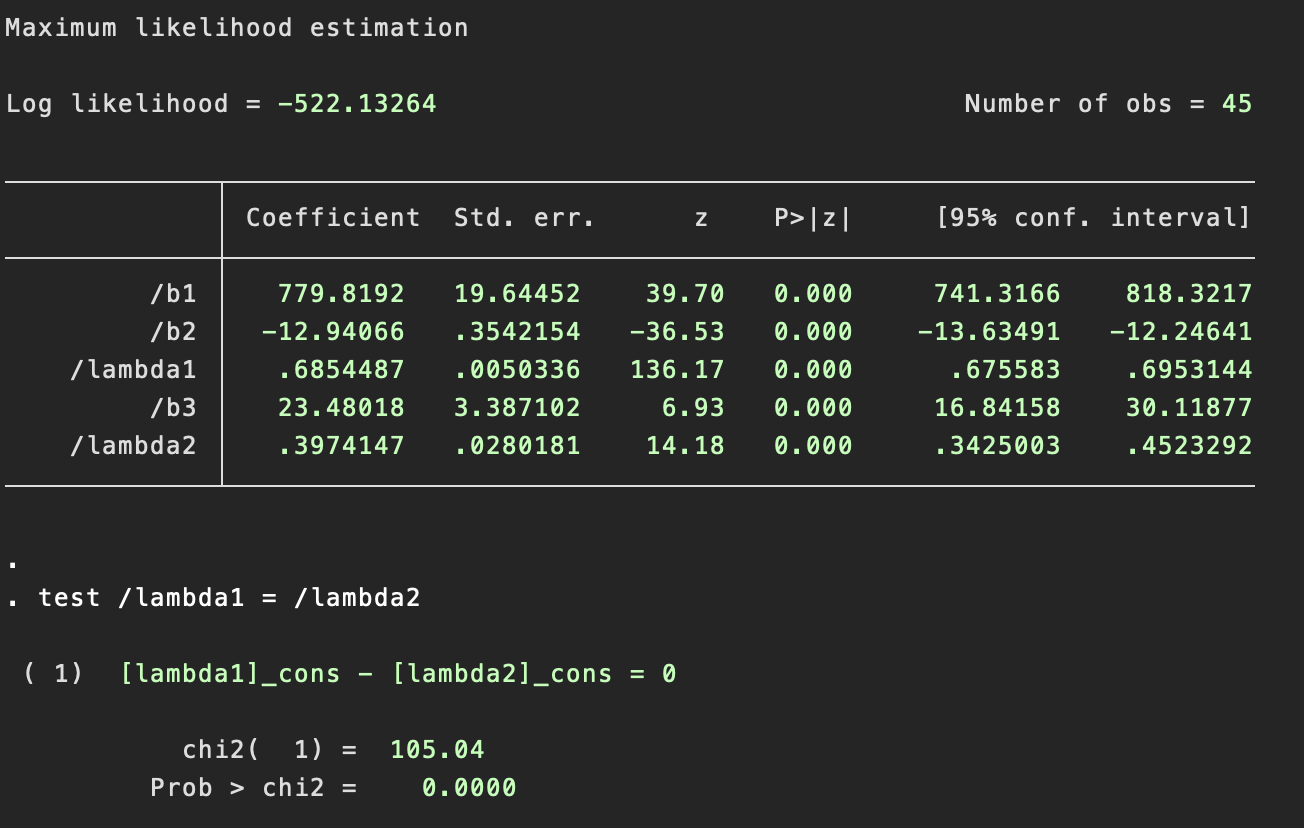

As the test indicates, $\lambda_1 \neq \lambda_2$, such that we choose the present model. 

## 2) Simulate a mixture of two normal populations

Assumptions: 

$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \epsilon$

$ x_1 \sim N(\mu_1, \sigma^2_1)$

$ x_2 \sim N(\mu_2, \sigma^2_2)$ 

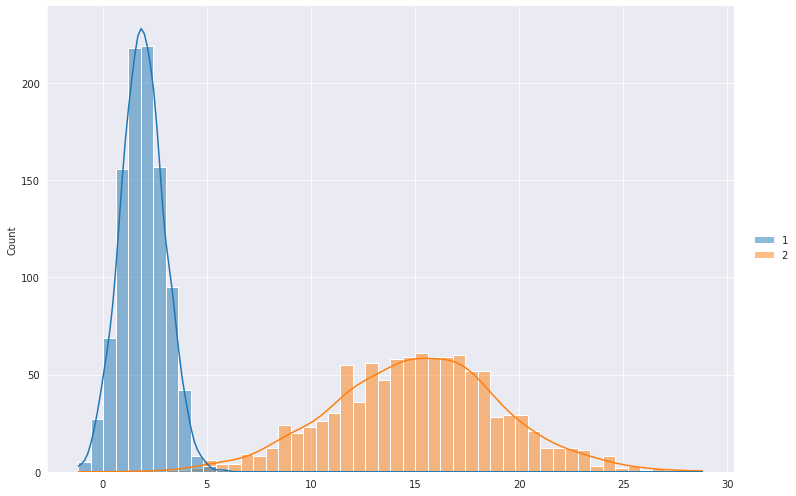

In [24]:
# Estipulate the parameters of the population
n=1000

#Generate x1
mu1 = 2
s1 = 1
x1 = np.random.normal(mu1,s1,n)

#Generate x2
mu2 = 15
s2 = 4
x2 = np.random.normal(mu2, s2, n)

#Generate error term:

e = np.random.normal(0,2,n)

#Create X matrix

X = np.array([np.ones(n), x1 , x2]).T
X = pd.DataFrame(X)
sns.displot(data=X.iloc[:,1:], bins=50, kde=True, height=7, aspect=1.5)


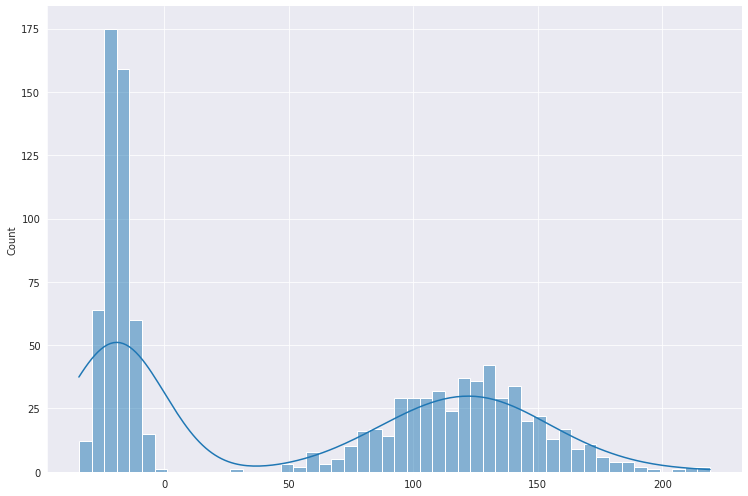

In [25]:
# Generate a 50/50 mixture of x1 and x2 – OK
mix_id = np.random.binomial(1, 0.50, 1000) 

# Generate Y as a random sample from each of these distributions

y = np.array([])
for i in range(0,n):
  if mix_id[i] ==1:
    y = np.append(y,5 + 6*x1[i] + 7*x2[i] + e[i])
  else:
    y = np.append(y,-2 + 0.5*x1[i] - 1.2*x2[i] + e[i])


sns.displot(y, bins=50, kde=True, height=7, aspect=1.5)

### a) Estimate the parameters ignoring the mixture

In [26]:
# Estimate y 
model1 = sm.OLS(y,X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     15.65
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           2.02e-07
Time:                        20:18:59   Log-Likelihood:                -5705.0
No. Observations:                1000   AIC:                         1.142e+04
Df Residuals:                     997   BIC:                         1.143e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.1515      9.899      0.116      0.9

### b) Estimate the parametes considering the mixture

Now we will export the data to run the Finite Mixture Model on Stata using the ```fmm``` command:

In [27]:
y = pd.Series(y)
data = pd.concat([y,X], axis=1)
data.columns = ['y','cons','x1','x2']
data.to_excel('data_2.xlsx')

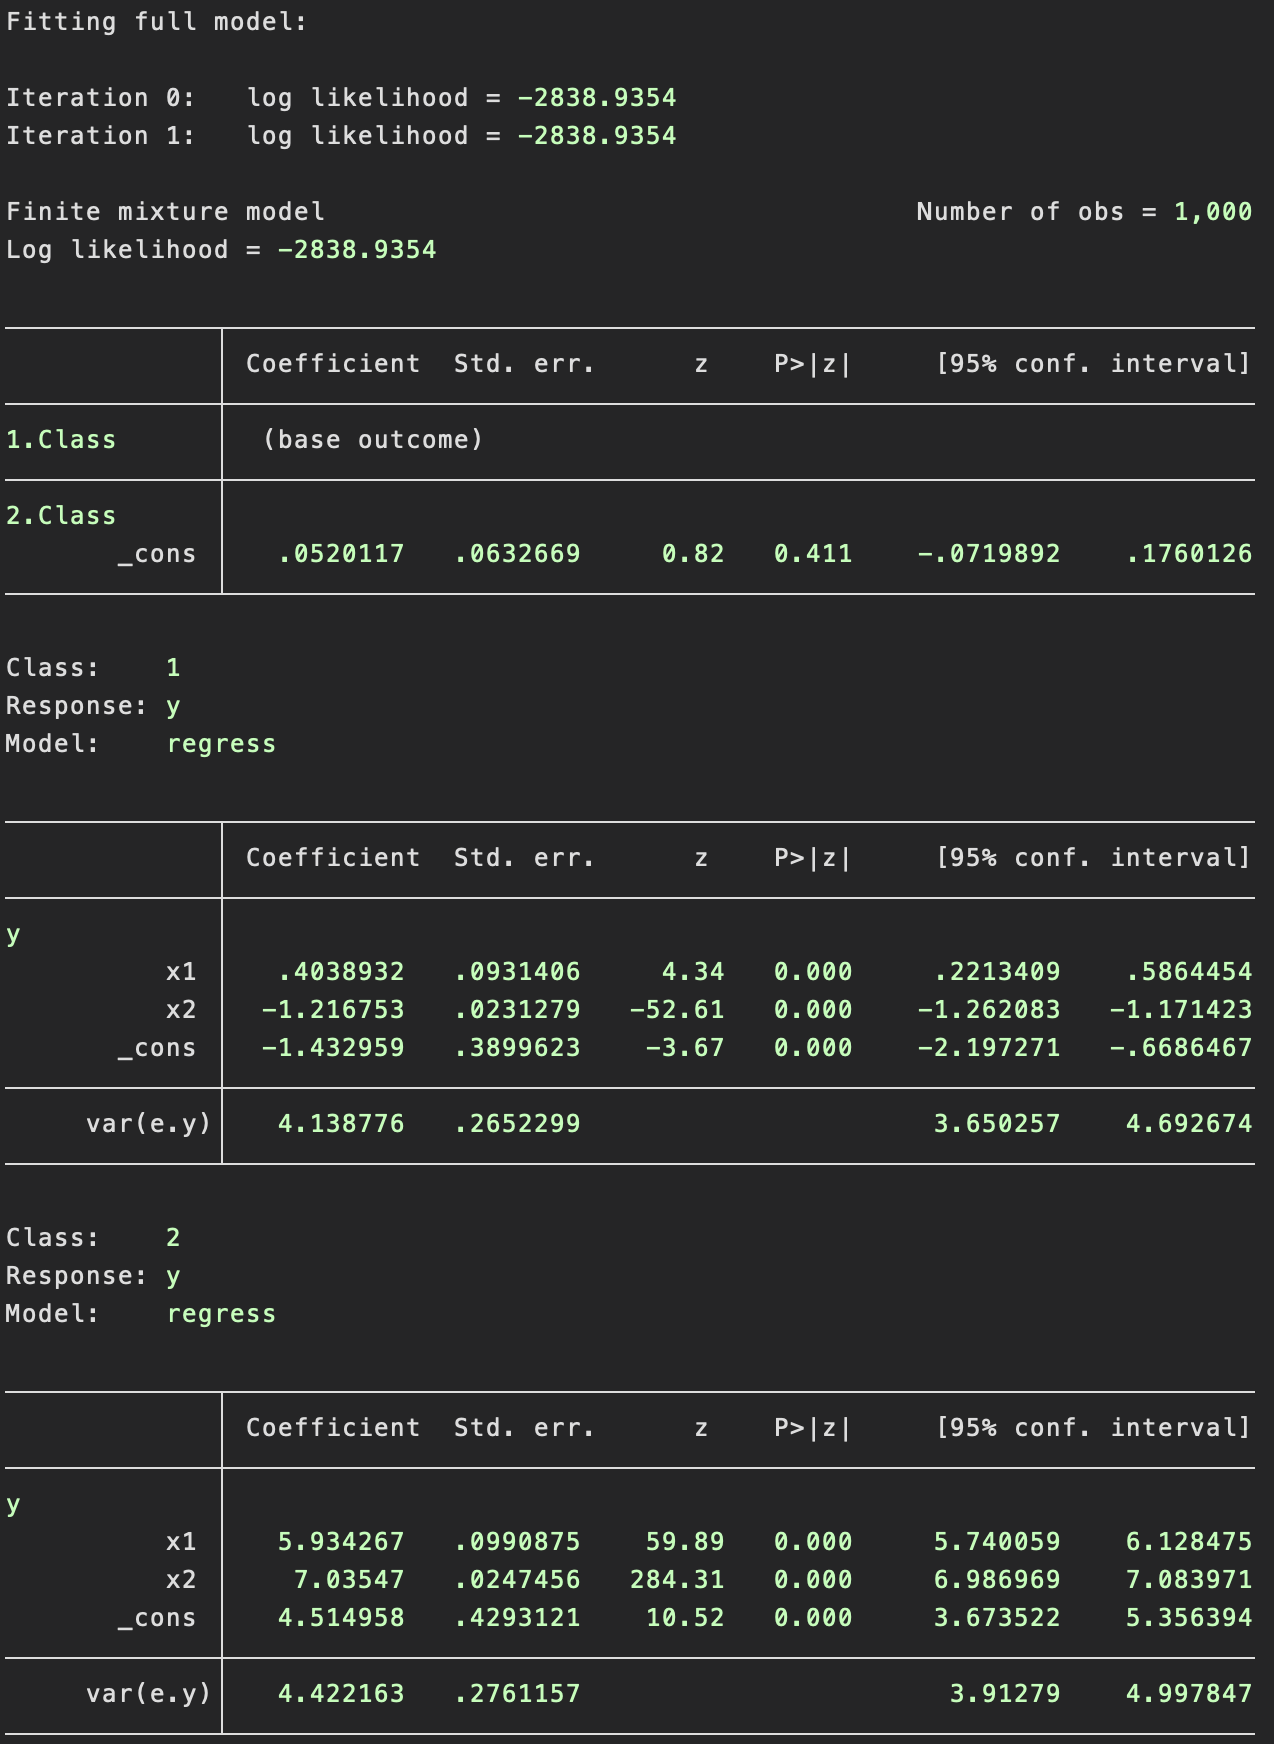

In the first step, Stata tries to sort out the observations into two groups. Subsequently, given each group, Stata estimates the underlying model for the group. While Stata does not know our order for the groups, it can be seen that Class 1 is equivalent to our ```id==0```, whereas Class 2 corresponds to our ```id==1```.

The first table provides the probability of Class 2 event happening (i.e. the proportion of observations connected to group two). The results indicate 48/52, which is only a rough approximation to our 50/50 mixture, such the results are not significantly. 

The following two tables estimate the coefficients for each predicted data generating processes.


Class 1 model in Stata is equivalent to our ```id==0```. We should expect the values: cons = -2 ,  x1 = .5 , x2 = -1.2

Class 2 model corresponds to our ```id==1```. We should expect the values: cons=5 , x1 = 6, x2=7.

The coefficients are quite close to the real values. Importantly, in all estimations the 95% confidence interval contains the true population parameter.

Moreover, it does a much better job that our simple OLS in part (a).


## 3) Monte Carlo Simulation

Simulate 1000 observations of a variable $income$ and a variable $gender$ and use these covariates to simulate 1000 observations of the number of credit card frauds using the Poisson distribution with $\lambda_i = exp(x_i'\beta)$

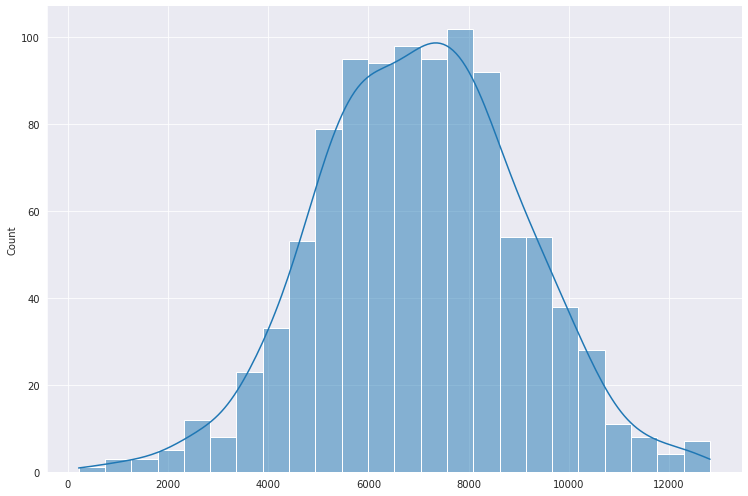

In [63]:
# Assume mean monthly income is $7000 with a variance of $2000
income = np.abs(np.random.normal(7000,2000,n))
sns.displot(income, kde=True, height=7, aspect=1.5)

In [64]:
# Assume 55% of credit card owners are women
female = np.random.binomial(1, 0.55, 1000) 
print("In our sample, we have " + str(np.sum(female)) + " women.")

In our sample, we have 529 women.


Let's assume that the number of credit card frauds is given by:

$Fraud = exp(\beta_0 + \beta_1Income + \beta_2Female)$

$Fraud = exp(5 + -0.0005Income -0,025Female)$

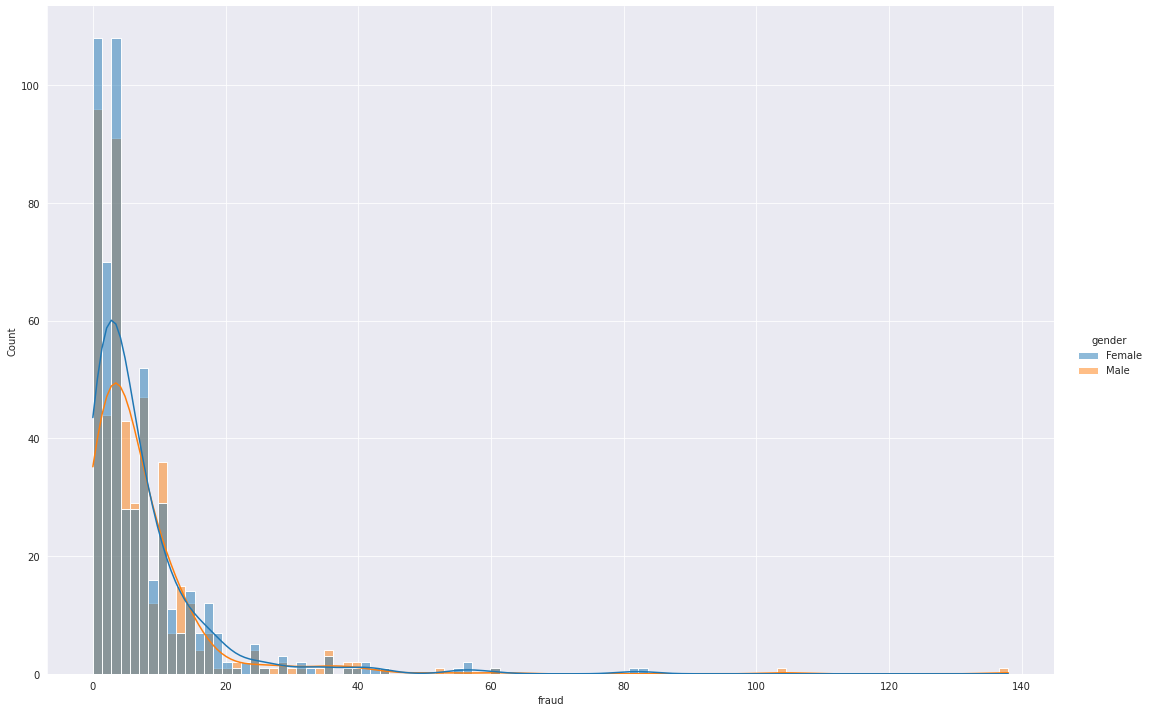

In [68]:
# Generate X matrix
X = X = np.array([np.ones(n), income , female]).T
X = pd.DataFrame(X, columns=['cons','income', 'female'])

# Apply data generating process
Xb = 5 + -0.0005*income -0.025*female

# Create Lambda
l = np.exp(Xb)

fraud = np.random.poisson(l,n)
y = pd.Series(fraud)
data = pd.concat([y, X], axis=1).rename(columns={0:'fraud','female':'gender'})
data.gender = data.gender.replace({1:'Female', 0:'Male'})

sns.displot(data=data, x='fraud', hue='gender', kde=True, height=10, aspect=1.5)


### a) Assuming linearity, estimate the $\beta$ parameters

In [69]:
#Generate 
print(sm.OLS(fraud,X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     542.4
Date:                Mon, 10 Oct 2022   Prob (F-statistic):          4.09e-160
Time:                        20:44:05   Log-Likelihood:                -3374.8
No. Observations:                1000   AIC:                             6756.
Df Residuals:                     997   BIC:                             6770.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons          32.9418      0.845     38.968      0.0

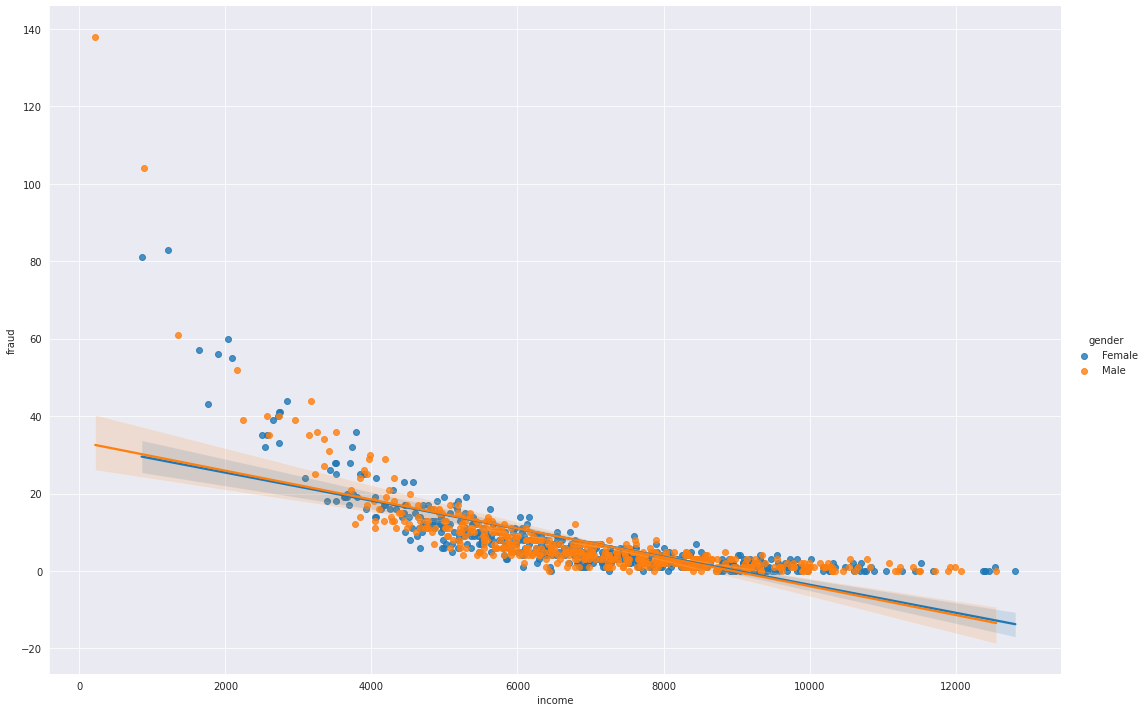

In [70]:
sns.lmplot(x='income', y='fraud', hue='gender', data=data, height=10, aspect=1.5)

### b) Use Maximum Likelihood to estimate the β parameters

In [71]:
print(Poisson(fraud, X).fit().summary())

Optimization terminated successfully.
         Current function value: 2.101981
         Iterations 16
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                 1000
Model:                        Poisson   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 10 Oct 2022   Pseudo R-squ.:                  0.6388
Time:                        20:44:17   Log-Likelihood:                -2102.0
converged:                       True   LL-Null:                       -5819.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons           4.9659      0.033    149.878      0.000       4.901       5.031
income        -0.0005   5.68

### c) What do you conclude
 

 It can be seen that the Maximum Likelihood estimation does a much better job in finding coefficients that approximate the true population parameters. The intercept and $\beta_2$ are nearly identical to the true values, while $\beta_1$ is spot on.

The linear regression, on the other hand, has to overestimate the intercept to account for outliers generated by the non-linear effect. This generates bias in the estimates, especially towards the tails of the distribution, as it can be seen in the regression plot (which is a mere approximation of our linear model, since the female dummy is an intercept shifter in our model, but is represented as a slope shifter in the plot). 

Evidently, we should utilize the Maximum Likelihood Estimator.
